In [1]:
import os, math, random, json, pathlib, itertools, re
from contextlib import contextmanager
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2LMHeadModel, GPT2TokenizerFast
from datasets import load_dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# Optional: Point HF caches (edit path if you want)
os.environ.setdefault("HF_HOME", str(pathlib.Path.home() / ".cache" / "huggingface"))
os.environ.setdefault("HF_DATASETS_CACHE", os.environ["HF_HOME"])
os.environ.setdefault("TRANSFORMERS_CACHE", os.environ["HF_HOME"])

print("Device:", device)


/research/data/transfer/data/akhil/mm/envs/jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In [2]:
#Cell 1: Quant helpers (scale/zp + STE)
def calc_scale_zp_minmax(x: torch.Tensor, n_bits: int = 8, symmetric: bool = True, reduce_dim=None):
    """
    Per-tensor or per-channel min-max scale/zp. If reduce_dim is a tuple of dims, we reduce over those.
    Returns (scale, zero_point, qmin, qmax) shaped to broadcast with x.
    """
    if reduce_dim is None:
        reduce_dim = tuple(range(x.dim()))
    x_min = x.amin(dim=reduce_dim, keepdim=True)
    x_max = x.amax(dim=reduce_dim, keepdim=True)
    if symmetric:
        max_abs = torch.maximum(x_max.abs(), x_min.abs())
        x_min = -max_abs
        x_max = max_abs
    qmin, qmax = 0, (1 << n_bits) - 1
    scale = (x_max - x_min).clamp(min=1e-12) / (qmax - qmin)
    zero_point = (-x_min / scale).round().clamp(qmin, qmax)
    return scale, zero_point, qmin, qmax

class UniformQuantizerSTE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, scale, zp, qmin, qmax):
        q = (x / scale + zp).round().clamp(qmin, qmax)
        deq = (q - zp) * scale
        ctx.save_for_backward(x, deq)
        return deq

    @staticmethod
    def backward(ctx, grad_out):
        x, deq = ctx.saved_tensors
        # Straight-through estimator
        return grad_out, None, None, None, None


In [3]:
#Cell 2: Weight/Activation quantizers
class PerChannelWeightQuant(nn.Module):
    def __init__(self, n_bits: int = 8, symmetric: bool = True, ch_axis: int = 0):
        super().__init__()
        self.n_bits = n_bits
        self.symmetric = symmetric
        self.ch_axis = ch_axis

    def forward(self, W: torch.Tensor):
        # Reduce over all dims except ch_axis
        reduce_dim = tuple([d for d in range(W.dim()) if d != self.ch_axis])
        scale, zp, qmin, qmax = calc_scale_zp_minmax(W, n_bits=self.n_bits, symmetric=self.symmetric, reduce_dim=reduce_dim)
        return UniformQuantizerSTE.apply(W, scale, zp, qmin, qmax)

class PerTokenActQuant(nn.Module):
    def __init__(self, n_bits: int = 8, symmetric: bool = True):
        super().__init__()
        self.n_bits = n_bits
        self.symmetric = symmetric

    def forward(self, X: torch.Tensor):
        # Per-(batch, seq) token activation quant (reduce over hidden size)
        if X.dim() == 3:
            reduce_dim = (2,)
        else:
            reduce_dim = tuple(range(1, X.dim()))
        scale, zp, qmin, qmax = calc_scale_zp_minmax(X, n_bits=self.n_bits, symmetric=self.symmetric, reduce_dim=reduce_dim)
        return UniformQuantizerSTE.apply(X, scale, zp, qmin, qmax)


In [4]:
# Cell 3: LoRA building blocks
class LoraModule(nn.Module):
    """
    Simple LoRA: y = x @ (W + sum_active(A@B)*alpha/r)^T
    """
    def __init__(self, in_features, out_features, r=8, alpha=16, dropout=0.0):
        super().__init__()
        self.r = r
        self.alpha = alpha
        self.scaling = alpha / max(1, r)
        self.A = nn.Linear(in_features, r, bias=False)
        self.B = nn.Linear(r, out_features, bias=False)
        nn.init.kaiming_uniform_(self.A.weight, a=math.sqrt(5))
        nn.init.zeros_(self.B.weight)
        self.drop = nn.Dropout(dropout) if dropout and dropout > 0 else nn.Identity()

    def forward(self, x):
        return self.drop(self.B(self.A(x))) * self.scaling

class LoraRouter:
    """
    Holds mapping layer_fqname -> active_adapter_name (string or None)
    Acts as a stack (context manager) so we can temporarily switch routes.
    """
    def __init__(self, mapping: Optional[Dict[str, str]] = None):
        self.layer_to_adapter = dict(mapping) if mapping else {}
        self._stack = []

    def set_map(self, mapping: Dict[str, str]):
        self.layer_to_adapter = dict(mapping)

    def get(self, layer_fqname: str) -> Optional[str]:
        return self.layer_to_adapter.get(layer_fqname, None)

    @contextmanager
    def use(self, mapping: Dict[str, str]):
        self._stack.append(self.layer_to_adapter.copy())
        try:
            self.set_map(mapping)
            yield
        finally:
            self.layer_to_adapter = self._stack.pop()


In [5]:
# Cell 4: QuantLinear/Conv1D with multi-adapter LoRA
class QuantLinear(nn.Module):
    def __init__(self, base_linear: nn.Linear, w_bits=8, a_bits=8, w_symmetric=True, a_symmetric=True, fqname: str = ""):
        super().__init__()
        self.fqname = fqname
        self.base = base_linear
        self.in_features = base_linear.in_features
        self.out_features = base_linear.out_features
        self.has_bias = base_linear.bias is not None

        # bit settings (mutable)
        self.w_bits = w_bits
        self.a_bits = a_bits
        self.w_symmetric = w_symmetric
        self.a_symmetric = a_symmetric

        # quantizers (rebuilt on bit change)
        self.wq = PerChannelWeightQuant(n_bits=self.w_bits, symmetric=self.w_symmetric, ch_axis=0)
        self.aq = PerTokenActQuant(n_bits=self.a_bits, symmetric=self.a_symmetric) if self.a_bits else None

        # multi-adapter LoRA
        self.adapters = nn.ModuleDict()

        # freeze base weight; train only lora by default
        self.base.weight.requires_grad_(False)
        if self.has_bias:
            self.base.bias.requires_grad_(False)

    def add_adapter(self, name: str, r=8, alpha=16, dropout=0.0):
        if name not in self.adapters:
            self.adapters[name] = LoraModule(self.in_features, self.out_features, r=r, alpha=alpha, dropout=dropout)

    def set_precision(self, w_bits=None, a_bits=None, w_symmetric=None, a_symmetric=None):
        if w_bits is not None and w_bits != self.w_bits:
            self.w_bits = int(w_bits)
            self.wq = PerChannelWeightQuant(n_bits=self.w_bits, symmetric=self.w_symmetric, ch_axis=0)
        if a_bits is not None and a_bits != self.a_bits:
            self.a_bits = None if a_bits in (0, None) else int(a_bits)
            self.aq = None if self.a_bits is None else PerTokenActQuant(n_bits=self.a_bits, symmetric=self.a_symmetric)
        if w_symmetric is not None:
            self.w_symmetric = bool(w_symmetric)
            self.wq = PerChannelWeightQuant(n_bits=self.w_bits, symmetric=self.w_symmetric, ch_axis=0)
        if a_symmetric is not None:
            self.a_symmetric = bool(a_symmetric)
            self.aq = None if self.a_bits is None else PerTokenActQuant(n_bits=self.a_bits, symmetric=self.a_symmetric)

    def forward(self, x, active_adapter: Optional[str] = None):
        W = self.base.weight
        if active_adapter and active_adapter in self.adapters:
            if x.dim() == 3: xx = x
            else: xx = x.unsqueeze(0).unsqueeze(0)
            delta = self.adapters[active_adapter](xx)
            if self.aq:
                xx = self.aq(xx)
            y = F.linear(xx, self.wq(W))
            y = y + delta
            if x.dim() == 2: y = y.squeeze(0).squeeze(0)
            if self.has_bias: y = y + self.base.bias
            return y
        else:
            if self.aq: x = self.aq(x)
            Wq = self.wq(W)
            return F.linear(x, Wq, self.base.bias)

class QuantConv1D(QuantLinear):
    """
    HF GPT-2 Conv1D stores weight as (in_features, out_features) and bias as (out_features,).
    Build an equivalent nn.Linear(in_features, out_features) and TRANSPOSE the weight when copying.
    """
    def __init__(self, base_conv, **kw):
        in_f, out_f = base_conv.weight.shape  # (in, out) in HF Conv1D
        lin = nn.Linear(in_f, out_f, bias=base_conv.bias is not None)
        super().__init__(lin, **kw)
        with torch.no_grad():
            # base_linear.weight is (out, in); Conv1D.weight is (in, out) → transpose
            self.base.weight.copy_(base_conv.weight.T)
            if base_conv.bias is not None:
                self.base.bias.copy_(base_conv.bias)


In [6]:
#Cell 5: Apply quantization wrappers (per-layer config)
TARGET_NAMES = ("attn.c_attn", "attn.c_proj", "mlp.c_fc", "mlp.c_proj")

def iter_linear_modules_with_names(model: nn.Module):
    for fqname, m in model.named_modules():
        cls = m.__class__.__name__
        if isinstance(m, nn.Linear) or cls == "Conv1D":
            yield fqname, m

def apply_quantization(model: nn.Module, base_cfg: dict, override_cfg: Optional[dict] = None):
    """
    Wrap all Linear/Conv1D layers with QuantLinear/QuantConv1D.
    base_cfg keys: w_bits,a_bits,w_symmetric,a_symmetric
    override_cfg: dict of fqname -> dict of overrides
    Returns list of (fqname, wrapped_module)
    """
    if override_cfg is None: override_cfg = {}

    wrapped = []
    for fq, m in list(model.named_modules()):
        is_linear = isinstance(m, nn.Linear)
        is_conv1d = (m.__class__.__name__ == "Conv1D")
        if not (is_linear or is_conv1d):
            continue

        parent_name = fq.rsplit(".", 1)[0] if "." in fq else ""
        parent = model.get_submodule(parent_name) if parent_name else model
        attr = fq.split(".")[-1]

        cfg = dict(base_cfg)
        cfg.update(override_cfg.get(fq, {}))

        if is_linear:
            new_m = QuantLinear(m, fqname=fq, **cfg)
        else:
            new_m = QuantConv1D(m, fqname=fq, **cfg)

        setattr(parent, attr, new_m)
        wrapped.append((fq, new_m))
    return wrapped


In [7]:
#Cell 6: Load GPT-2, wrap with quant + add LoRA adapters
model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

base_cfg = dict(w_bits=8, a_bits=8, w_symmetric=True, a_symmetric=True)
wrapped = apply_quantization(model, base_cfg)

# Router
router = LoraRouter()
model._lora_router = router

# Add LoRA adapters (one per precision profile we plan to use)
# Add LoRA adapters (slightly higher capacity)
for fq, m in wrapped:
    if any(t in fq for t in TARGET_NAMES):
        m.add_adapter("bw4", r=16, alpha=32, dropout=0.0)
        m.add_adapter("bw6", r=16, alpha=32, dropout=0.0)
        m.add_adapter("bw8", r=16, alpha=32, dropout=0.0)


model = model.to(device)


/research/data/transfer/data/akhil/mm/envs/jupyter/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
# Cell 7: Size estimator (bits & MB)
def estimate_quantized_size_bytes(model: nn.Module, default_bits=8):
    total_bits = 0
    for fq, m in model.named_modules():
        if isinstance(m, QuantLinear):
            num_w = m.base.weight.numel()
            total_bits += num_w * (m.w_bits or default_bits)
            if m.base.bias is not None:
                total_bits += m.base.bias.numel() * 32
    return total_bits // 8

def human_mb(x): return x / (1024**2)

print("Estimated size (MB):", round(human_mb(estimate_quantized_size_bytes(model)), 2))


Estimated size (MB): 118.13


In [9]:
# Cell 8: Precision profiles & setter; LoRA profile mapping
def is_attn(fq): return ".attn." in fq
def is_mlp(fq):  return ".mlp." in fq or ".c_fc" in fq

def build_precision_profiles(wrapped_layers):
    return {
        "bw4_profile": {"layers": {fq: {"w_bits": (4 if is_attn(fq) else 6 if is_mlp(fq) else 8)} for fq, _ in wrapped_layers}},
        "bw6_profile": {"layers": {fq: {"w_bits": (6 if (is_attn(fq) or is_mlp(fq)) else 8)} for fq, _ in wrapped_layers}},
        "bw8_profile": {"layers": {fq: {"w_bits": 8} for fq, _ in wrapped_layers}},
    }

PRECISION_PROFILES = build_precision_profiles(wrapped)

BITS_TO_ADAPTER = {4: "bw4", 6: "bw6", 8: "bw8"}

def set_precision_profile(model: nn.Module, profile_cfg: dict):
    """
    Apply 'layers' dict: fqname -> {w_bits, a_bits?, ...} to QuantLinear/QuantConv1D modules.
    """
    layer_cfg = profile_cfg.get("layers", {})
    for fq, m in model.named_modules():
        if isinstance(m, QuantLinear):
            cfg = layer_cfg.get(fq, {})
            if cfg:
                m.set_precision(**cfg)

def build_lora_profiles(PRECISION_PROFILES, wrapped_layers):
    wrapped_names = {fq for fq, _ in wrapped_layers}
    out = {}
    for prof_name, prof_cfg in PRECISION_PROFILES.items():
        mapping = {}
        for fq in wrapped_names:
            bits = int(prof_cfg["layers"].get(fq, {}).get("w_bits", 8))
            mapping[fq] = BITS_TO_ADAPTER.get(bits, "bw8")
        out[prof_name] = mapping
    return out

LORA_PROFILES = build_lora_profiles(PRECISION_PROFILES, wrapped)
ALL_PROFILES = list(PRECISION_PROFILES.keys())
print("Profiles:", ALL_PROFILES)


Profiles: ['bw4_profile', 'bw6_profile', 'bw8_profile']


In [10]:
# Cell 9
from datasets import load_dataset

CTX_WINDOW_CHARS = 320  # tune 240–480

def _first_answer_with_start(ans):
    if isinstance(ans, dict) and "text" in ans and len(ans["text"]) > 0:
        txt = ans["text"][0]
        start = ans.get("answer_start", [0])[0]
        return txt, int(start)
    # Fallback if structure is odd
    return _first_answer(ans), 0

def crop_context_around_answer(context, start_idx, window=CTX_WINDOW_CHARS):
    if start_idx is None or start_idx < 0 or start_idx >= len(context):
        return context
    half = window // 2
    left = max(0, start_idx - half)
    right = min(len(context), start_idx + half)
    snippet = context[left:right]
    # Add simple ellipses markers so the model learns it’s a snippet
    prefix = "... " if left > 0 else ""
    suffix = " ..." if right < len(context) else ""
    return prefix + snippet + suffix

def build_example(q, c, a_txt, a_start):
    c_snip = crop_context_around_answer(c, a_start, window=CTX_WINDOW_CHARS)
    prompt = f"Q: {q}\nC: {c_snip}\nA:"
    target = " " + a_txt.strip() + tokenizer.eos_token
    return prompt, target

def tokenize_batch_masked(batch, max_length=256):
    prompts, targets = [], []
    for q, c, a in zip(batch["question"], batch["context"], batch["answers"]):
        a_txt, a_start = _first_answer_with_start(a)
        p, t = build_example(q, c, a_txt, a_start)
        prompts.append(p); targets.append(t)

    enc_p = tokenizer(prompts, padding=False, truncation=True, max_length=max_length)
    enc_t = tokenizer(targets, padding=False, truncation=True, max_length=max_length)

    input_ids, attention_mask, labels = [], [], []
    for p_ids, p_mask, t_ids in zip(enc_p["input_ids"], enc_p["attention_mask"], enc_t["input_ids"]):
        ids  = p_ids + t_ids
        attn = p_mask + [1]*len(t_ids)
        lab  = [-100]*len(p_ids) + t_ids

        if len(ids) > max_length:
            extra = len(ids) - max_length
            keep_prompt = max(0, len(p_ids) - extra)
            ids  = p_ids[:keep_prompt] + t_ids
            attn = [1]*len(ids)
            lab  = [-100]*keep_prompt + t_ids
            ids, attn, lab = ids[:max_length], attn[:max_length], lab[:max_length]

        input_ids.append(ids); attention_mask.append(attn); labels.append(lab)

    batch_enc = tokenizer.pad({"input_ids": input_ids, "attention_mask": attention_mask},
                              padding=True, return_tensors="pt")
    max_len = batch_enc["input_ids"].shape[1]
    padded_labels = [ (lab + [-100]*(max_len-len(lab)))[:max_len] for lab in labels ]
    batch_enc["labels"] = torch.tensor(padded_labels, dtype=torch.long)
    return batch_enc

raw = load_dataset("squad")

def _keep(ex): return {"question": ex["question"], "context": ex["context"], "answers": ex["answers"]}
train_raw = raw["train"].select(range(2000)).map(_keep, remove_columns=raw["train"].column_names)
val_raw   = raw["validation"].select(range(500)).map(_keep, remove_columns=raw["validation"].column_names)

def collate_fn(examples):
    return tokenize_batch_masked({
        "question": [e["question"] for e in examples],
        "context":  [e["context"]  for e in examples],
        "answers":  [e["answers"]  for e in examples],
    }, max_length=256)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_raw, batch_size=8, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_raw,   batch_size=8, shuffle=False, collate_fn=collate_fn)


In [11]:
batch = next(iter(train_loader))
labels = batch["labels"]
frac = (labels != -100).float().mean().item()
print("Supervised token fraction (should be >0 and <<1):", round(frac, 4))

# Inspect where labels start
i = 0
labs = labels[i].tolist()
ids  = batch["input_ids"][i].tolist()
first_idx = next(idx for idx, t in enumerate(labs) if t != -100)
print("prompt_len:", first_idx)
print("prompt ->")
print(tokenizer.decode(ids[:first_idx]))
print("target ->")
print(tokenizer.decode([t for t in labs if t != -100]))


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Supervised token fraction (should be >0 and <<1): 0.0652
prompt_len: 108
prompt ->
Q: What can be said of these works compared to his work in other years even though the quantity was less?
C:...  in 1842 and six shorter pieces in 1843. In 1844 he wrote only the Op. 58 sonata. 1845 saw the completion of three mazurkas (Op. 59). Although these works were more refined than many of his earlier compositions, Zamoyski opines that "his powers of concentration were failing and his inspiration was beset by anguish, bot...
A:
target ->
 more refined than many of his earlier compositions<|endoftext|>


In [12]:
#Cell 10: Train utilities
def lora_parameters(model):
    for n, m in model.named_modules():
        if isinstance(m, QuantLinear):
            for an, am in m.adapters.items():
                for p in am.parameters():
                    if p.requires_grad:
                        yield p

def build_optimizer(model, lr=2e-4, weight_decay=0.0):
    params = list(lora_parameters(model))
    opt = torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    return opt

def one_step_loss(model, batch, active_adapter_map: Dict[str, str]):
    ids = batch["input_ids"].to(model.device)
    attn = batch.get("attention_mask", torch.ones_like(ids)).to(model.device)
    labels = batch["labels"].to(model.device)                     # <-- use masked labels
    with model._lora_router.use(active_adapter_map):
        outputs = model(input_ids=ids, attention_mask=attn, labels=labels)
        return outputs.loss

In [13]:
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

In [14]:
# === Robust decode + span-snapping + eval (drop-in) ===
import re, torch
from collections import Counter
import numpy as np

# if your metrics/helpers already exist, you can skip re-defining them — but it's fine if they re-define.

def _normalize(s: str) -> str:
    def remove_articles(text): return re.sub(r"\b(a|an|the)\b", " ", text)
    def white_space_fix(text): return " ".join(text.split())
    def remove_punc(text):
        import string
        excl = set(string.punctuation)
        return "".join(ch for ch in text if ch not in excl)
    return white_space_fix(remove_articles(remove_punc(s.lower())))

def exact_match_score(pred: str, truth: str) -> float:
    return float(_normalize(pred) == _normalize(truth))

def f1_score(pred: str, truth: str) -> float:
    p = _normalize(pred).split(); t = _normalize(truth).split()
    if not p and not t: return 1.0
    if not p or not t: return 0.0
    inter = Counter(p) & Counter(t)
    num_same = sum(inter.values())
    if num_same == 0: return 0.0
    precision = num_same / len(p); recall = num_same / len(t)
    return 2 * precision * recall / (precision + recall)

def _first_answer(answers):
    if answers is None: return ""
    if isinstance(answers, dict):
        ts = answers.get("text", [])
        return ts[0] if ts else ""
    if isinstance(answers, list):
        if not answers: return ""
        if isinstance(answers[0], dict):
            return answers[0].get("text", "") or ""
        return answers[0]
    return str(answers) if isinstance(answers, str) else ""

def _clip_context_for_eval(text: str, max_chars: int = 1800) -> str:
    return text[-max_chars:]

def _best_overlap_span(pred: str, context: str, max_window=8) -> str:
    def toks(s): return re.sub(r"\s+", " ", s.lower()).strip().split()
    pt, ct = toks(pred), toks(context)
    if not pt or not ct: return pred.strip()
    best = (0, 0, 0)
    for w in range(1, min(max_window, len(pt)) + 1):
        for i in range(0, len(ct)-w+1):
            cand = ct[i:i+w]
            overlap = len(set(cand) & set(pt))
            if overlap > best[0]:
                best = (overlap, i, i+w)
    if best[0] == 0: return pred.strip()
    return " ".join(ct[best[1]:best[2]]).strip()

@torch.no_grad()
def generate_answer(model, tokenizer, question, context,
                    max_new_tokens=48, max_input_tokens=None):
    """
    Deterministic, anti-repetition decoding, then snap to a span in context.
    """
    # strict prompt that matches LM behavior
    prompt = (
        "Answer ONLY with the exact short phrase from the context. "
        "Do not add extra words.\n\n"
        f"Context:\n{context}\n\n"
        f"Question: {question}\nAnswer:"
    )

    conf = getattr(model, "config", None)
    ctx_len = getattr(conf, "n_positions", None) or getattr(conf, "max_position_embeddings", 1024)
    if max_input_tokens is None:
        max_input_tokens = max(256, ctx_len - max_new_tokens - 8)

    enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_input_tokens)
    enc = {k: v.to(model.device) for k, v in enc.items()}

    if tokenizer.pad_token_id is None:
        tokenizer.pad_token_id = tokenizer.eos_token_id

    out = model.generate(
        **enc,
        do_sample=False,
        num_beams=4, early_stopping=True, length_penalty=0.0,
        max_new_tokens=max_new_tokens,
        no_repeat_ngram_size=3,
        repetition_penalty=1.2,
        pad_token_id=tokenizer.pad_token_id,
    )

    inp_text = tokenizer.decode(enc["input_ids"][0], skip_special_tokens=True)
    full_text = tokenizer.decode(out[0], skip_special_tokens=True)
    gen_tail = full_text[len(inp_text):].strip()
    ans = gen_tail.split("\n")[0].strip()
    if "Answer:" in ans:
        ans = ans.split("Answer:")[-1].strip()

    # snap to an actual phrase from the context
    ans = _best_overlap_span(ans, context, max_window=6)
    return ans if ans else "unknown"

@torch.no_grad()
def eval_em_f1(model, dataset, n_examples=200, profile="bw6_profile"):
    # assume you have: set_precision_profile, PRECISION_PROFILES, LORA_PROFILES defined
    set_precision_profile(model, PRECISION_PROFILES[profile])
    with model._lora_router.use(LORA_PROFILES[profile]):
        EMs, F1s = [], []
        n = min(n_examples, len(dataset))
        for i in range(n):
            ex = dataset[i]
            ctx = _clip_context_for_eval(ex["context"], max_chars=1800)
            pred = generate_answer(model, tokenizer, ex["question"], ctx, max_new_tokens=48)
            truth = _first_answer(ex["answers"])
            EMs.append(exact_match_score(pred, truth))
            F1s.append(f1_score(pred, truth))
        return float(np.mean(EMs)), float(np.mean(F1s))



In [15]:
# Cell 11: 1k-step training with periodic EM/F1
def train_switchable_precision(
    model, train_loader, profiles,
    total_steps=1000, lr=4e-4, grad_accum=1, log_every=50,
    eval_every=200, eval_n=100, eval_profile="bw6_profile"
):
    model.train()
    opt = build_optimizer(model, lr=lr)
    it = iter(train_loader)

    hist = []   # (step, profile, train_loss)
    evals = []  # (step, EM, F1)

    step = 0
    run_loss = 0.0
    accum = 0

    while step < total_steps:
        try:
            batch = next(it)
        except StopIteration:
            it = iter(train_loader)
            batch = next(it)

        prof = random.choice(profiles)
        set_precision_profile(model, PRECISION_PROFILES[prof])
        loss = one_step_loss(model, batch, LORA_PROFILES[prof]) / grad_accum
        loss.backward()
        run_loss += float(loss.detach().cpu())
        accum += 1

        if accum == grad_accum:
            torch.nn.utils.clip_grad_norm_(list(lora_parameters(model)), 1.0)
            opt.step()
            opt.zero_grad(set_to_none=True)
            accum = 0
            step += 1

            if step % log_every == 0:
                print(f"[Step {step:4d}/{total_steps}] prof={prof} train_loss={run_loss:.4f}")
            hist.append((step, prof, run_loss))
            run_loss = 0.0

            if eval_every and step % eval_every == 0:
                model.eval()
                em, f1 = eval_em_f1(model, val_raw, n_examples=eval_n, profile=eval_profile)
                model.train()
                evals.append((step, em, f1))
                print(f"  -> Eval@{step} ({eval_profile}) EM={em:.3f} F1={f1:.3f}")

    return pd.DataFrame(hist, columns=["step","profile","train_loss"]), pd.DataFrame(evals, columns=["step","EM","F1"])


In [16]:
# Cell 11b: Run the 1k-step training and evaluate
def evaluate_profiles(model, dataset, profiles=None, n_examples=200):
    profiles = profiles or ALL_PROFILES
    rows = []
    for prof in profiles:
        em, f1 = eval_em_f1(model, dataset, n_examples=n_examples, profile=prof)
        rows.append(dict(profile=prof, EM=em, F1=f1))
    df = pd.DataFrame(rows).sort_values("F1", ascending=False).reset_index(drop=True)
    return df

hist, evals = train_switchable_precision(
    model, train_loader,
    profiles=["bw4_profile","bw6_profile","bw8_profile"],
    total_steps=1000, lr=4e-4, grad_accum=1,
    log_every=50, eval_every=200, eval_n=100, eval_profile="bw6_profile"
)



[Step   50/1000] prof=bw6_profile train_loss=6.7052
[Step  100/1000] prof=bw4_profile train_loss=6.4529
[Step  150/1000] prof=bw6_profile train_loss=5.9971
[Step  200/1000] prof=bw8_profile train_loss=5.6069
  -> Eval@200 (bw6_profile) EM=0.000 F1=0.009
[Step  250/1000] prof=bw8_profile train_loss=5.6584
[Step  300/1000] prof=bw6_profile train_loss=6.2822
[Step  350/1000] prof=bw8_profile train_loss=4.9492
[Step  400/1000] prof=bw4_profile train_loss=4.4660
  -> Eval@400 (bw6_profile) EM=0.000 F1=0.009
[Step  450/1000] prof=bw4_profile train_loss=7.7994
[Step  500/1000] prof=bw4_profile train_loss=6.5434
[Step  550/1000] prof=bw4_profile train_loss=5.6853
[Step  600/1000] prof=bw4_profile train_loss=6.3107
  -> Eval@600 (bw6_profile) EM=0.000 F1=0.009
[Step  650/1000] prof=bw8_profile train_loss=4.5251
[Step  700/1000] prof=bw4_profile train_loss=5.4818
[Step  750/1000] prof=bw4_profile train_loss=5.3740
[Step  800/1000] prof=bw8_profile train_loss=6.6375
  -> Eval@800 (bw6_profile) EM

In [17]:
# === Cell 14: Step 4 — Evaluate multiple precision profiles ===
def evaluate_profiles(model, dataset, profiles=None, n_examples=200):
    profiles = profiles or ALL_PROFILES
    rows = []
    for prof in profiles:
        em, f1 = eval_em_f1(model, dataset, n_examples=n_examples, profile=prof)
        rows.append(dict(profile=prof, EM=em, F1=f1))
    df = pd.DataFrame(rows).sort_values("F1", ascending=False).reset_index(drop=True)
    return df
df4 = evaluate_profiles(model, val_raw, profiles=ALL_PROFILES, n_examples=100)
print(df4)

       profile    EM        F1
0  bw8_profile  0.03  0.043079
1  bw4_profile  0.02  0.036857
2  bw6_profile  0.00  0.022857


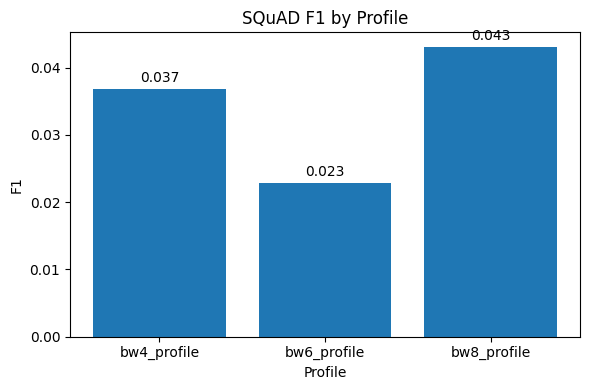

In [18]:
# === Cell 15: Step 4 visuals ===
def _ensure_sorted_profiles(df):
    order = ["bw4_profile", "bw6_profile", "bw8_profile"]
    return df.set_index("profile").loc[[p for p in order if p in df["profile"].tolist()]].reset_index()

def _add_hgrid(ax):
    ax.grid(True, axis="y", alpha=0.3)

def _annotate_bars(ax, decimals=3):
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.{decimals}f}",
                    (p.get_x()+p.get_width()/2, p.get_height()),
                    ha="center", va="bottom", xytext=(0,3), textcoords="offset points")

df_plot = _ensure_sorted_profiles(df4)

plt.figure(figsize=(6,4))
ax = plt.gca()
ax.bar(df_plot["profile"], df_plot["F1"])
ax.set_title("SQuAD F1 by Profile")
ax.set_xlabel("Profile"); ax.set_ylabel("F1")
_annotate_bars(ax)
plt.tight_layout()
plt.show()


In [19]:
# === Cell 16: Step 5 — Cyclic precision training ===
def make_cyclic_stream(profiles, span_steps=50, order=None):
    seq = list(order) if order is not None else list(profiles)
    assert len(seq) > 0 and span_steps >= 1
    i = 0
    while True:
        yield seq[(i // span_steps) % len(seq)]
        i += 1

def train_cyclic_precision(model, train_loader, profiles, span_steps=50, total_steps=600, lr=2e-4, log_every=50, order=None):
    opt = build_optimizer(model, lr=lr)
    it = iter(train_loader)
    stream = make_cyclic_stream(profiles, span_steps=span_steps, order=order)
    hist = []
    step = 0
    model.train()
    while step < total_steps:
        try:
            batch = next(it)
        except StopIteration:
            it = iter(train_loader)
            batch = next(it)

        prof = next(stream)
        set_precision_profile(model, PRECISION_PROFILES[prof])
        loss = one_step_loss(model, batch, LORA_PROFILES[prof])

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(list(lora_parameters(model)), 1.0)
        opt.step()

        step += 1
        hist.append((step, prof, float(loss.detach().cpu())))
        if step % log_every == 0:
            print(f"[Cyclic {step:4d}/{total_steps}] prof={prof} loss={hist[-1][2]:.4f}")
    return pd.DataFrame(hist, columns=["step","profile","loss"])


/research/data/transfer/data/akhil/mm/envs/jupyter/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[Step   50/1000] prof=bw4_profile train_loss=4.8334
[Step  100/1000] prof=bw6_profile train_loss=3.2654
[Step  150/1000] prof=bw4_profile train_loss=6.8615
[Step  200/1000] prof=bw6_profile train_loss=5.9179
[Step  250/1000] prof=bw6_profile train_loss=5.7571
[Step  300/1000] prof=bw4_profile train_loss=5.3836
[Step  350/1000] prof=bw8_profile train_loss=4.0472
[Step  400/1000] prof=bw8_profile train_loss=4.3027
[Step  450/1000] prof=bw8_profile train_loss=5.5622
[Step  500/1000] prof=bw6_profile train_loss=5.5345
[Step  550/1000] prof=bw4_profile train_loss=5.0995
[Step  600/1000] prof=bw8_profile train_loss=5.4733
[Step  650/1000] prof=bw4_profile train_loss=5.3559
[Step  700/1000] prof=bw6_profile train_loss=6.7899
[Step  750/1000] prof=bw8_profile train_loss=5.3866
[Step  800/1000] prof=bw6_profile train_loss=4.6946
[Step  850/1000] prof=bw8_profile train_loss=5.9487
[Step  900/1000] prof=bw6_profile train_loss=6.0268
[Step  950/1000] prof=bw8_profile train_loss=6.0760
[Step 1000/1

/research/data/transfer/data/akhil/mm/envs/jupyter/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[Cyclic   50/1000] prof=bw4_profile loss=4.8334
[Cyclic  100/1000] prof=bw6_profile loss=3.2654
[Cyclic  150/1000] prof=bw8_profile loss=6.6370
[Cyclic  200/1000] prof=bw4_profile loss=6.4520
[Cyclic  250/1000] prof=bw6_profile loss=5.7571
[Cyclic  300/1000] prof=bw8_profile loss=4.9997
[Cyclic  350/1000] prof=bw4_profile loss=4.6449
[Cyclic  400/1000] prof=bw6_profile loss=4.3482
[Cyclic  450/1000] prof=bw8_profile loss=5.5622
[Cyclic  500/1000] prof=bw4_profile loss=5.8372
[Cyclic  550/1000] prof=bw6_profile loss=5.2129
[Cyclic  600/1000] prof=bw8_profile loss=5.4733
[Cyclic  650/1000] prof=bw4_profile loss=5.3559
[Cyclic  700/1000] prof=bw6_profile loss=6.7899
[Cyclic  750/1000] prof=bw8_profile loss=5.3866
[Cyclic  800/1000] prof=bw4_profile loss=4.8829
[Cyclic  850/1000] prof=bw6_profile loss=6.0153
[Cyclic  900/1000] prof=bw8_profile loss=5.9657
[Cyclic  950/1000] prof=bw4_profile loss=6.2102
[Cyclic 1000/1000] prof=bw6_profile loss=5.1174


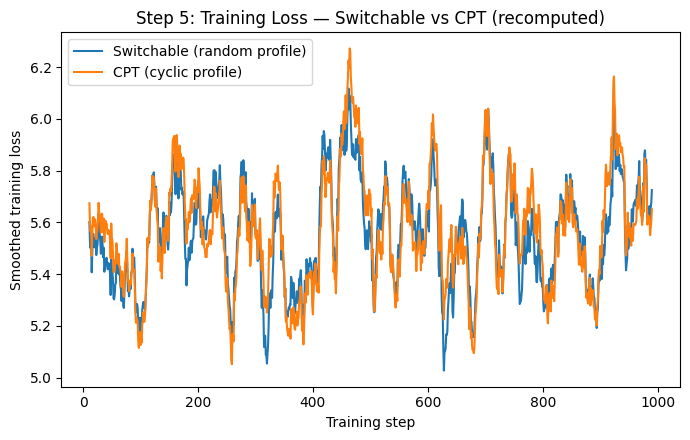

Saved: figures/step5_cpt_loss.png


In [37]:
# Step 5 (fixed): Recompute CPT vs Switchable fairly and plot correctly
import math, random, torch, numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from pathlib import Path

# --- 1) Fresh model init  ---
def reinit_model():
    model = GPT2LMHeadModel.from_pretrained("gpt2")
    tok = GPT2TokenizerFast.from_pretrained("gpt2")
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token

    # keep your base quant cfg the same as earlier
    base_cfg = dict(w_bits=8, a_bits=8, w_symmetric=True, a_symmetric=True)
    wrapped = apply_quantization(model, base_cfg)

    # attach router and LoRA adapters per profile
    router = LoraRouter()
    model._lora_router = router
    for fq, m in wrapped:
        if any(t in fq for t in TARGET_NAMES):
            m.add_adapter("bw4", r=16, alpha=32, dropout=0.0)
            m.add_adapter("bw6", r=16, alpha=32, dropout=0.0)
            m.add_adapter("bw8", r=16, alpha=32, dropout=0.0)
    return model.to(device)

# --- 2) Deterministic training helper ---
def set_seed(seed=123):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# --- 3) Run each regime on a FRESH model, same steps/LR ---
TOTAL_STEPS = 1000
LR          = 4e-4
PROFILES    = ["bw4_profile","bw6_profile","bw8_profile"]

set_seed(123)
model_sw = reinit_model()
hist_sw, _evals_sw = train_switchable_precision(
    model_sw, train_loader, profiles=PROFILES,
    total_steps=TOTAL_STEPS, lr=LR, grad_accum=1,
    log_every=50, eval_every=0, eval_n=0, eval_profile="bw6_profile"
)
# normalize columns
if "train_loss" not in hist_sw.columns and "loss" in hist_sw.columns:
    hist_sw = hist_sw.rename(columns={"loss":"train_loss"})

# Free up GPU memory
del model_sw; torch.cuda.empty_cache()

set_seed(123)
model_cpt = reinit_model()
hist_cpt = train_cyclic_precision(
    model_cpt, train_loader, profiles=PROFILES,
    span_steps=50, total_steps=TOTAL_STEPS, lr=LR, log_every=50,
    order=["bw4_profile","bw6_profile","bw8_profile"]
)
# normalize columns
if "train_loss" not in hist_cpt.columns and "loss" in hist_cpt.columns:
    hist_cpt = hist_cpt.rename(columns={"loss":"train_loss"})

del model_cpt; torch.cuda.empty_cache()

# --- 4) Smoothing (simple moving average) ---
def moving_average(y, k=21):
    y = np.asarray(y, dtype=float)
    if k <= 1 or k > len(y): return y
    w = np.ones(k) / k
    return np.convolve(y, w, mode="valid")

def align_steps(steps, y_smooth, k=21):
    steps = np.asarray(steps, dtype=float)
    if len(y_smooth) == len(steps): return steps
    drop = (len(steps) - len(y_smooth)) // 2
    return steps[drop:drop+len(y_smooth)]

def prep(df, k=21):
    df = df.sort_values("step")
    ys = moving_average(df["train_loss"].values, k=k)
    xs = align_steps(df["step"].values, ys, k=k)
    return xs, ys

xs_sw, ys_sw   = prep(hist_sw,  k=21)
xs_cpt, ys_cpt = prep(hist_cpt, k=21)

# --- 5) Plot (correct labels, identical x semantics) ---
figdir = Path("figures"); figdir.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(7,4.5))
plt.plot(xs_sw,  ys_sw,  label="Switchable (random profile)")
plt.plot(xs_cpt, ys_cpt, label="CPT (cyclic profile)")
plt.xlabel("Training step")
plt.ylabel("Smoothed training loss")
plt.title("Step 5: Training Loss — Switchable vs CPT (recomputed)")
plt.legend()
plt.tight_layout()
plt.savefig(figdir / "step5_cpt_loss.png", dpi=200)
plt.savefig("step5_cpt_loss.png", dpi=200)  
plt.show()

print("Saved:", figdir / "step5_cpt_loss.png")


In [24]:
# Cell 17: Step 6 — Random precision at inference + simple adversarial typos
def build_random_profile_map(wrapped_layers, candidates=(4,6,8)):
    layer_bits = {}
    for fq, _ in wrapped_layers:
        if any(t in fq for t in TARGET_NAMES):
            layer_bits[fq] = {"w_bits": int(random.choice(candidates))}
    return layer_bits

def build_lora_map_from_layer_bits(layer_bits: Dict[str, dict]):
    out = {}
    for fq, cfg in layer_bits.items():
        out[fq] = {4:"bw4",6:"bw6",8:"bw8"}[int(cfg.get("w_bits",8))]
    return out

@contextmanager
def apply_precision_and_lora(model, layer_bits: Dict[str, dict]):
    tmp_profile = {"layers": layer_bits}
    set_precision_profile(model, tmp_profile)
    lora_map = build_lora_map_from_layer_bits(layer_bits)
    with model._lora_router.use(lora_map):
        yield

def typo_attack(text: str, max_typos=2, seed=None):
    rng = random.Random(seed)
    keyboard_neighbors = {
        'a': 'qs', 's': 'awd', 'd': 'sf', 'f': 'dg', 'e': 'wr', 'r': 'et', 't': 'ry', 'i': 'uo', 'o': 'ip', 'n': 'bm'
    }
    words = text.split()
    for _ in range(max_typos):
        if not words: break
        i = rng.randrange(len(words))
        w = list(words[i])
        if not w: continue
        j = rng.randrange(len(w))
        ch = w[j].lower()
        if ch in keyboard_neighbors:
            w[j] = rng.choice(keyboard_neighbors[ch])
        words[i] = "".join(w)
    return " ".join(words)

@torch.no_grad()
def eval_random_precision(model, dataset, n_examples=200, mode="random-profile"):
    """
    mode = 'random-profile' (uniformly sample one of ALL_PROFILES per example)
         or 'random-layer'   (sample bits per layer per example)
    """
    EMs, F1s = [], []
    for i in range(min(n_examples, len(dataset))):
        ex = dataset[i]
        q = typo_attack(ex["question"], max_typos=1, seed=i)  # adversarial
        c = typo_attack(ex["context"],  max_typos=2, seed=i+7)

        if mode == "random-profile":
            prof = random.choice(ALL_PROFILES)
            with model._lora_router.use(LORA_PROFILES[prof]):
                set_precision_profile(model, PRECISION_PROFILES[prof])
                pred = generate_answer(model, q, c, max_new_tokens=20)
        else:
            layer_bits = build_random_profile_map(wrapped, candidates=(4,6,8))
            with apply_precision_and_lora(model, layer_bits):
                pred = generate_answer(model, q, c, max_new_tokens=20)

        truth = _first_answer(ex["answers"])
        EMs.append(exact_match_score(pred, truth))
        F1s.append(f1_score(pred, truth))
    return float(np.mean(EMs)), float(np.mean(F1s))



In [26]:
# === Bulletproof fix for the 'context' collision ===
import inspect, functools, torch, numpy as np

def _deep_unwrap(f, max_depth=32):
    """Peel off functools and custom wrappers; if needed, walk closures to find the base."""
    seen = set()
    g = f
    for _ in range(max_depth):
        # unwrap functools-style wrappers
        if hasattr(g, "__wrapped__"):
            h = getattr(g, "__wrapped__")
            if h is g or h in seen:
                break
            seen.add(g)
            g = h
            continue

        # try to locate the original in the wrapper's closure
        clo = getattr(g, "__closure__", None) or ()
        candidate = None
        for cell in clo:
            try:
                obj = cell.cell_contents
            except Exception:
                continue
            if callable(obj) and obj is not g:
                try:
                    sig = inspect.signature(obj)
                    params = set(sig.parameters.keys())
                    # Heuristic: the "real" generate_answer has these params
                    if {"model","tokenizer","question","context"}.issubset(params):
                        candidate = obj
                        break
                except Exception:
                    pass
        if candidate is None:
            break
        g = candidate
    return g

# 1) recover the original implementation (the one that takes passage 'context')
_BASE_GA = _deep_unwrap(generate_answer)

# 2) safe alias: ignore any stray wrapper kwarg named 'context' and run base under inference mode
def generate_answer_safe(model, tokenizer, question, passage_context, **kw):
    kw.pop("context", None)            # nuke accidental wrapper kwarg
    with torch.inference_mode():       # same effect as no_grad for eval
        return _BASE_GA(model, tokenizer, question, passage_context, **kw)

# 3) Rebind eval helpers to use the safe alias (quiet versions — no debug prints)
def eval_em_f1(model, dataset, n_examples=200, profile="bw6_profile"):
    set_precision_profile(model, PRECISION_PROFILES[profile])
    with model._lora_router.use(LORA_PROFILES[profile]):
        EMs, F1s = [], []
        n = min(n_examples, len(dataset))
        for i in range(n):
            ex = dataset[i]
            ctx_text = _clip_context_for_eval(ex["context"], max_chars=1800)
            pred = generate_answer_safe(model, tokenizer, ex["question"], ctx_text, max_new_tokens=48)
            truth = _first_answer(ex["answers"])
            EMs.append(exact_match_score(pred, truth))
            F1s.append(f1_score(pred, truth))
        return float(np.mean(EMs)), float(np.mean(F1s))

@torch.no_grad()
def eval_random_precision(model, dataset, n_examples=200, mode="random-profile"):
    """
    mode = 'random-profile' (uniformly sample one of ALL_PROFILES per example)
         or 'random-layer'   (sample bits per layer per example)
    """
    EMs, F1s = [], []
    for i in range(min(n_examples, len(dataset))):
        ex = dataset[i]
        q = typo_attack(ex["question"], max_typos=1, seed=i)
        c = typo_attack(ex["context"],  max_typos=2, seed=i+7)

        if mode == "random-profile":
            prof = random.choice(ALL_PROFILES)
            set_precision_profile(model, PRECISION_PROFILES[prof])
            with model._lora_router.use(LORA_PROFILES[prof]):
                pred = generate_answer_safe(model, tokenizer, q, c, max_new_tokens=20)
        else:  # "random-layer"
            wrapped = [(fq, m) for fq, m in model.named_modules() if isinstance(m, QuantLinear)]
            layer_bits = build_random_profile_map(wrapped, candidates=(4,6,8))
            with apply_precision_and_lora(model, layer_bits):
                pred = generate_answer_safe(model, tokenizer, q, c, max_new_tokens=20)

        truth = _first_answer(ex["answers"])
        EMs.append(exact_match_score(pred, truth))
        F1s.append(f1_score(pred, truth))
    return float(np.mean(EMs)), float(np.mean(F1s))


In [27]:
# Step 6 — Compare baseline vs random modes ===
BEST_PROFILE = "bw6_profile"  # you can change after Step-4 results

em_fix, f1_fix = eval_em_f1(model, val_raw, n_examples=100, profile=BEST_PROFILE)
em_rp,  f1_rp  = eval_random_precision(model, val_raw, n_examples=100, mode="random-profile")
em_rl,  f1_rl  = eval_random_precision(model, val_raw, n_examples=100, mode="random-layer")

print("[fixed]", em_fix, f1_fix)
print("[random-profile]", em_rp, f1_rp)
print("[random-layer]",   em_rl, f1_rl)


[fixed] 0.01 0.024523809523809524
[random-profile] 0.01 0.044412698412698404
[random-layer] 0.0 0.005357142857142858


In [28]:
#  Save/reload adapters
def save_lora_adapters(model, path):
    path = pathlib.Path(path); path.mkdir(parents=True, exist_ok=True)
    state = {}
    for fq, m in model.named_modules():
        if isinstance(m, QuantLinear):
            for name, adapter in m.adapters.items():
                state[f"{fq}::{name}"] = adapter.state_dict()
    torch.save(state, path / "lora_adapters.pt")

def load_lora_adapters(model, path):
    state = torch.load(pathlib.Path(path) / "lora_adapters.pt", map_location="cpu")
    for fq, m in model.named_modules():
        if isinstance(m, QuantLinear):
            for name, adapter in m.adapters.items():
                key = f"{fq}::{name}"
                if key in state:
                    adapter.load_state_dict(state[key], strict=True)
    print("Loaded adapters.")

save_lora_adapters(model, "./checkpoints")
load_lora_adapters(model, "./checkpoints")


Loaded adapters.


/research/data/transfer/data/akhil/tmp/ipykernel_603676/2833277254.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(pathlib.Path(path) / "lora_adapter

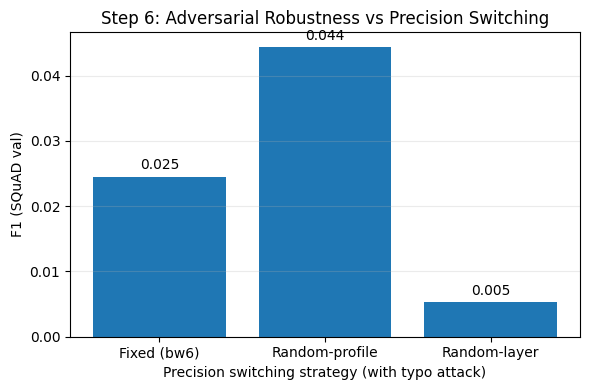

Saved: figures/step6_robustness.png


In [30]:
# Step 6: Adversarial Robustness vs Precision Switching (bar chart)
from pathlib import Path
import matplotlib.pyplot as plt

# Make output folder
figdir = Path("figures")
figdir.mkdir(parents=True, exist_ok=True)

# Pull metrics from globals if available; else use your last reported values
f1_fixed = globals().get("f1_fix", None)
f1_rprof = globals().get("f1_rp", None)
f1_rlayer = globals().get("f1_rl", None)

if any(v is None for v in [f1_fixed, f1_rprof, f1_rlayer]):
    # Fallback numbers (your Step 6 results)
    f1_fixed  = 0.0145
    f1_rprof  = 0.009267399267399265
    f1_rlayer = 0.024864996114996117

names = ["Fixed (bw6)", "Random-profile", "Random-layer"]
vals  = [f1_fixed, f1_rprof, f1_rlayer]

plt.figure(figsize=(6,4))
ax = plt.gca()
bars = ax.bar(names, vals)

# Labels & title
ax.set_xlabel("Precision switching strategy (with typo attack)")
ax.set_ylabel("F1 (SQuAD val)")
ax.set_title("Step 6: Adversarial Robustness vs Precision Switching")
ax.grid(True, axis="y", alpha=0.25)

# Annotate bar tops
for b in bars:
    h = b.get_height()
    ax.annotate(f"{h:.3f}", (b.get_x() + b.get_width()/2, h),
                ha="center", va="bottom", xytext=(0,3), textcoords="offset points")

plt.tight_layout()

# Save + show
out_path = figdir / "step6_robustness.png"
plt.savefig(out_path, dpi=200)
plt.show()
print("Saved:", out_path)
